# Assignment 2: Convolutional Neural Network (CNN)¶
## Deep Learning
### Wali Ullah (09745)

In [1]:
# keras imports for the dataset and building our neural network
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from keras.layers import BatchNormalization
import os
import cv2
import pickle
import matplotlib.pyplot as plt
import random
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D,BatchNormalization
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import os
import cv2
import pickle
import matplotlib.pyplot as plt
import random
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense,MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

# CNN Function to be called to build Network

A  neural network model is build to work for image recognition and facial detection. The relevant parts of the code are commented for better understanding. Below is common Convolutional Neural Network (CNN) function to be used for all three types of datsets. 

In [2]:

def Con_NeuralNetwok(filter_no,stride,padding_type, act_fn, input_shp ,bachnorm,drop_out, polsize, layer2,output_class,label,verbose=0):
    # building a linear stack of layers with the sequential model
    model = Sequential()

    # convolutional layer 1
    model.add(Conv2D(filter_no, kernel_size=(3,3), strides=stride, padding=padding_type, 
                     activation=act_fn, input_shape=input_shp))
    #Call for bach normalization
    if bachnorm=='yes':
        model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=polsize))
    model.add(Dropout(drop_out))
    
    #add layer 2: convolutional layer 2
    if layer2=='yes':
        model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
        if bachnorm=='yes':
            model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=polsize))
    
    model.add(Dropout(drop_out))
    # flatten output of conv
    model.add(Flatten())

    # hidden layer
    model.add(Dense(500, activation=act_fn))
    model.add(Dropout(0.4))
    model.add(Dense(250, activation=act_fn))
    model.add(Dropout(0.3))
    # output layer
    model.add(Dense(output_class, activation='softmax'))
    print(model.summary())
    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    # training the model for 10 epochs
    model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test))
    
    #Making confusion matrix that checks accuracy of the model
    Y_test_arg=np.argmax(Y_test,axis=1)
    Y_pred = np.argmax(model.predict(X_test),axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(Y_test_arg, Y_pred))
   
    test_acc = accuracy_score(Y_test_arg, Y_pred)
    print('test_acc:',test_acc)
    class_report = classification_report(Y_test_arg, Y_pred, labels=label)
    print(class_report)

# Dataset 1: Identifying Images from the CIFAR-10 Dataset using CNNs

The CIFAR-10 dataset consists of 60,000 32 x 32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

Description of the Original data

The original a batch data is (10000 x 3072) dimensional tensor expressed in numpy array, where the number of columns, (10000), indicates the number of sample data. As stated in the CIFAR-10/CIFAR-100 dataset, the row vector, (3072) represents an color image of 32x32 pixels.

Since this project is going to use CNN for the classification tasks, the row vector, (3072), is not an appropriate form of image data to feed. In order to feed an image data into a CNN model, the dimension of the tensor representing an image data should be either (width x height x num_channel) or (num_channel x width x height).

It depends on your choice (check out the tensorflow conv2d). In this particular project, I am going to use the dimension of the first choice because the default choice in tensorflow's CNN operation is so.

The row vector (3072) has the exact same number of elements if you calculate 32323==3072. In order to reshape the row vector, (3072), there are two steps required. The first step is involved with using reshape function in numpy, and the second step is involved with using transpose function in numpy as well.



In [3]:
# loading the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

The images are all pre-segmented (e.g. each image contains a single object), that the images all have the same square size of 32×32 pixels, and that the images are color. Therefore, we can load the images and use them for modeling almost immediately.

In [4]:
# # building the input vector from the 32x32 pixels
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

Since the output of our model is going to show the probabilities of where an image should be categorized as a prediction. There should be a vector having the same number of elements as the number of image classes. For instance, CIFAR-10 provides 10 different classes of image, so we need a vector in size of 10 as well. Each element represents the predicting probability of each classes.

Also, our model should be able to compare the prediction with the ground truth label. It means the shape of the label data should also be transformed into a vector in size of 10 too. Instead, because label is the ground truth, we set the value 1 to the corresponding element.

one_hot_encode function takes the input, x, which is a list of labels(ground truth). The total number of element in the list is the total number of samples in a batch. one_hot_encode function returns a 2 dimensional tensor, where the number of row is the size of the batch, and the number of column is the number of image classes.

The pixel values for each image in the dataset are unsigned integers in the range between no color and full color, or 0 and 255. We normalize the pixel values, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

We use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value. We can achieve this with the to_categorical() utility function.

In [5]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (50000, 1)
Shape after one-hot encoding:  (50000, 10)


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


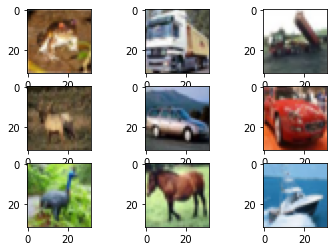

In [6]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot
from keras.datasets import fashion_mnist
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

# 1 [C+P]  (Bench Mark)

In [7]:
# Basic CNN Model with 1 (C+P)

#Basic Parameters for the CNN Function
filter_no=50   #Number of Filters in the Network50 and 75
stride=(1,1)   # Strides (1,1) and (2,2) etc
padding_type='valid'  # valid or same
act_fn='relu'       #relu and Leaky Relu etc
polsize=(2,2)         #pooling size   (2,2)  or (3,3) etc
drop_out=0.25     #change to 0 if no dropout
bachnorm='Yes'     # bachnormalization eitherr yes and No
layer2='No'
input_shp=(32, 32, 3)  # X shape
output_class=10        # Number of classes in output vector
label=[0, 1, 2, 3, 4,5,6,7,8,9]     #Labels for output classes

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 50)        1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 50)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11250)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               5625500   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0

#### Benchmark Framework
Here, we have considered the benchmark model with one convolution + pooling (C+P) layer and then fully connected Neural Network. Running the model in the test harness first prints the classification accuracy on the test dataset. The results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome. The model has 5,754,660 number of parameters.

In this case, we can see that the model achieved a classification accuracy of just less than 68%. The accuracy of individual classes varies in the range of 54 to 80%. The precision and recall are reasonable and vary in the range of 47 to 81%. The results seem reasonably well, however the accuracy and precision may improve with tuning the parameters.

This is the benchmark framework, and we compare the different framework with additional layers and hyperparameter tuning with this.


### 1) what effect does increasing to 2 (C+P) layers has on the performance?

Here we increase the number of CNN layers in the network from 1 to 2. All other parameters are same to the 1 (C+P) CNN, but we include the 2 CNN layer. Layer2 is changed from 'No' to 'Yes'.



In [8]:
#Basic Parameters are same to CNN 1(C+P) but layer2 is changed from 'No' to 'Yes' 
filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='Yes'           # Changed from 'No' to 'Yes'
input_shp=(32, 32, 3)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 50)        1400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11250)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               5625500   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)              

Here we have considered the two convolution + pooling 2(C+P) layer and then fully connected network. All  All other parameters are same to the 1 (C+P) CNN but we include the 2 CNN layer. Layer 2 is changed from 'No' to 'Yes'. The number of parameters is 5,754,660.

The results show that the overall accuracy is about 69%. With 10 epoches the loss is

Loss: 0.7642 - accuracy: 0.7276 - val_loss: 0.9089 - val_accuracy: 0.6820

The accuracy of individual classes vary in the range of 60 to 80%. The precision and recall are reasonable and vary in the range of 55 to 82%. The results indicate that with the addition of second (C+P) the results in terms of precision, recall and loss improve a bit, but not as much which were expected. The second (C+P) layer does not improve the results significantly.

Increasing the number of hidden layers might improve the accuracy or might not, it really depends on the complexity of the problem that you are trying to solve. Where in the left picture they try to fit a linear function to the data By adding more layers and more units within a layer, a deep network can represent functions of increasing complexity. Traditionally, it has been challenging to train neural network models with more than a few layers due to problems such as vanishing gradients. Depending upon how large your dataset is, the CNN architecture is implemented. Adding layers unnecessarily to any CNN will increase your number of parameters only for the smaller dataset, say in 1000s (total 1000). It’s true for some reasons that on adding more hidden layers, it will give more accuracy. This is true for larger datasets, as more layers with less stride factor will extract more features for your input data. In CNN, how you play with your architecture is completely dependent on what your requirement is and how your data is. There is term called “Overfitting” and “Underfitting”. Increasing Unnecessary parameters will only overfit your network. Say, when you are classifying between the two fruits, take apple and grapes. What can be the possible features that can distinguish only on the basis of visual features. It may be their edges, curves, shape, color, number of seeds inside. But if we give the smell factor to it. Will the machine be able to distinguish the two fruits without using any sensor? The answer is clearly “No”. So, providing this unnecessary smell factor, will not only increase your parameters but will also affect your accuracy. So, this is the example of Overfitting.

### 2) What happens to performance when I add and remove dropout? (Use 1 C+P)

Here, we use the basic parameters used in CNN 1(C+P) but change the dropout. we change the dropout from 0.25 to 0.0 (means no dropout). All other parameters are same to the 1 (C+P) CNN.

In [9]:
#Basic Parameters are same to CNN 1(C+P) but dropout is changed from 0.25 to 0.0 
filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.0     #changed from 0.25 to 0
bachnorm='Yes'     
layer2='No'
input_shp=(32, 32, 3)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 50)        1400      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 50)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11250)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               5625500   
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)              

Here we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the dropout from 0.25 to 0.0 (means no dropout). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 5,754,660.

The results show that the overall accuracy is about 67%. With 10 epochs the loss is about 

loss: 0.6772 - accuracy: 0.7593 - val_loss: 0.9638 - val_accuracy: 0.6737


The accuracy of individual classes varies in the range of 60 to 80%. The precision and recall are reasonable and vary in the range of 52 to 79%.
The results indicate that with no dropout the results in terms of accuracy, loss, precision, and recall becomes a bit worsen as compared to the benchmark model (1(C+P) with the dropout of 0.25).

The Dropout is used to prevent the model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase. With dropout (dropout rate less than some small value), the accuracy will gradually increase, and loss will gradually decrease first (That is what is happening in your case). When you increase dropout beyond a certain threshold, it results in the model not being able to fit properly. Usually, dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus, they're likely to excessively co-adapting themselves causing overfitting. However, since it's a stochastic regularization technique, you can really place it everywhere.


### 3) What happens to performance when I add and remove Batch Normalization? (Use 1 C+P)

Here, we use the basic parameters used in CNN 1(C+P) but change the Batch Normalization. we change the Batch Normalization (bachnorm) from 'yes' to 'No' (means no Batch Normalization). All other parameters are same to the 1 (C+P) CNN.

In [10]:
#Basic Parameters are same to CNN 1(C+P) but Batch Normalization (bachnorm) is changed from 'yes' to 'No'
filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25    
bachnorm='No'     #changed from yes and No
layer2='No'
input_shp=(32, 32, 3)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 50)        1400      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 50)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 11250)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               5625500   
_________________________________________________________________
dropout_14 (Dropout)         (None, 500)              

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the Batch Normalization (bachnorm) from 'yes' to 'No' (means no Batch Normalization). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 5,754,660.

The results show that the overall accuracy is about 69%. With 10 epochs the loss is about 0.9236.

loss: 0.7595 - accuracy: 0.7326 - val_loss: 0.9236 - val_accuracy: 0.6831

The accuracy of individual classes varies in the range of 60 to 80%. The precision and recall are reasonable and vary in the range of 57 to 85%.

The results indicate that with no batch normalization the prediction performance improves in terms of accuracy, loss, precision, and recall becomes a bit worsen as compared to the benchmark model (1 C+P) with batch normalization). When i remove batch normalization i see that loss is going to decrease and the accuracy of model increased up to sufficient number which i think is good in case of CNN, because we have to obtain high performance with high accuracy to get the detection of any object clearly


### 4) What happens to performance when I use valid and same paddings? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the Paddings. we change the Paddings (padding_type) from 'valid' to 'same'. All other parameters are same to the 1 (C+P) CNN.

In [11]:
#Basic Parameters are same to CNN 1(C+P) but Padding is changed from 'Valid' to 'Same'
filter_no=50   
stride=(1,1)   
padding_type='same'  #changed fro valid to same
act_fn='relu'      
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='No'
input_shp=(32, 32, 3)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 50)        1400      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 50)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 50)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               6400500   
_________________________________________________________________
dropout_18 (Dropout)         (None, 500)              

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the Paddings (padding_type) from 'valid' to 'same'. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 6,529,660.

The results show that there is no significant change in outcome. The overall accuracy is about 67% a bit smaller to the one we have in valid padding. With 10 epochs the loss is about 0.94, which is a bit higher than the one obtained in case of valid padding.

loss: 0.8241 - accuracy: 0.7076 - val_loss: 0.9425 - val_accuracy: 0.6693

The accuracy of individual classes varies in the range of 58 to 80%. The precision and recall are reasonable and vary in the range of 48 to 85%. The results indicate that there is no significant change in the performance of Neural Network with changing the padding type. The minor change in result may be due to the change in split of test and training data and epochs.

The Same Padding applies padding to the input image so that the input image gets fully covered by the filter and specified stride. It is called SAME because, for stride 1, the output will be the same as the input.

Same Padding

loss: 0.8241 - accuracy: 0.7076 - val_loss: 0.9425 - val_accuracy: 0.6693

Valid Padding (Benchmark)

loss: 0.7633 - accuracy: 0.7289 - val_loss: 0.9322 - val_accuracy: 0.6750



### 5) What happens to performance when I increase number of filters? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the number the filter (increase the number of filters). we change the number of filters (filter_no) from 50 to 75. All other parameters are same to the 1 (C+P) CNN.

In [12]:
#Basic Parameters are same to CNN 1(C+P) but change the number of filters (filter_no) from 50 to 75
filter_no=75   # changed from 50 to 75
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='No'
input_shp=(32, 32, 3)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 75)        2100      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 75)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 15, 15, 75)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 15, 75)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16875)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               8438000   
_________________________________________________________________
dropout_22 (Dropout)         (None, 500)              

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the number of filters (filter_no) from 50 to 75. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 8,567,860.

The results show that there is no significant change in outcome. The overall accuracy is about 69% a bit higher than the one we have in case of filter number is equal to 50. With 10 epochs the loss is about 0.9095, which is a significantly smaller than the one obtained in case of 50 filters.

loss: 0.7368 - accuracy: 0.7365 - val_loss: 0.9095 - val_accuracy: 0.6882

The accuracy of individual classes varies in the range of 56 to 80%. The precision and recall are reasonable and vary in the range of 52 to 82%. The results indicate that there is significant change in the performance of Neural Network with changing the number of filters. The accuracy has improved, and the loss has fallen.

Loss with filter number==75

loss: 0.7368 - accuracy: 0.7365 - val_loss: 0.9095 - val_accuracy: 0.6882

Loss with filter number==50, (Benchmark)

loss: 0.7633 - accuracy: 0.7289 - val_loss: 0.9322 - val_accuracy: 0.6750




### 6) What happens to performance when I use different pooling sizes? (Use 1 C+P and total 2 filter sizes only)

Here, we use the basic parameters as used in CNN 1(C+P) but change the pooling size (polsize). we change the pooling size (polsize) from (2,2) to (3,3). All other parameters are same to the 1 (C+P) CNN.

In [13]:
#Basic Parameters are same to CNN 1(C+P) but change the pooling size (polsize) from (2,2) to (3,3)

filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(3,3)         # changed from (2,2) to (3,3)
drop_out=0.25     
bachnorm='Yes'     
layer2='No'
input_shp=(32, 32, 3)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 50)        1400      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 50)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 10, 10, 50)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 10, 10, 50)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 500)               2500500   
_________________________________________________________________
dropout_26 (Dropout)         (None, 500)              

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the pooling size (polsize) from (2,2) to (3,3). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 2,629,660.

As CNN uses pooling layers to reduce the size of the input image so that it speeds up the computation of the network. Pooling or spatial pooling layers: Also called subsampling or down sampling. Overfitting can happen when your dataset is not large enough to accommodate your number of features. Max pooling uses a max operation to pool sets of features, leaving you with a smaller number of them. Therefore, max pooling should logically reduce over fit.

As pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity (e.g. ReLU) has been applied to the feature maps output by a convolutional layer; for example the layers in a model may look as follows:

Input Image

Convolutional Layer

Nonlinearity

Pooling Layer The addition of a pooling layer after the convolutional layer is a common pattern used for ordering layers within a convolutional neural network that may be repeated one or more times in a given model. The pooling layer operates upon each feature map separately to create a new set of the same number of pooled feature maps.
Pooling involves selecting a pooling operation, much like a filter to be applied to feature maps. The size of the pooling operation or filter is smaller than the size of the feature map; specifically, it is almost always 2×2 pixels applied with a stride of 2 pixels.

This means that the pooling layer will always reduce the size of each feature map by a factor of 2, e.g., each dimension is halved, reducing the number of pixels or values in each feature map to one quarter the size. For example, a pooling layer applied to a feature map of 6×6 (36 pixels) will result in an output pooled feature map of 3×3 (9 pixels).


The results show that there is significant change in outcome. The overall accuracy is about 70%, higher than the one we have in case of pooling size (polsize) is (2,2). With 10 epochs the loss is about 0.8625, which is a significantly smaller than the one obtained in case of 50 filters.

loss: 0.8275 - accuracy: 0.7092 - val_loss: 0.8625 - val_accuracy: 0.6986

The accuracy of individual classes varies in the range of 56 to 82%. The precision and recall are reasonable and vary in the range of 56 to 88%. The results indicate that there is significant change in the performance of Neural Network with changing the pooling size (polsize) from (2,2) to (3,3). The accuracy as well as the precision/recall has improved, and the loss has fallen.

Loss with Pooling size (polsize) is (3,3)

loss: 0.8275 - accuracy: 0.7092 - val_loss: 0.8625 - val_accuracy: 0.6986

Loss with Pooling size (polsize) is (2,2), (Benchmark)

loss: 0.7633 - accuracy: 0.7289 - val_loss: 0.9322 - val_accuracy: 0.6750


### 7) Is there a difference in performance if I use ReLU or Leaky Relu? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the activation function (act_fn). we change the activation function (act_fn) from ReLU to Leaky Relu. All other parameters are same to the 1 (C+P) CNN.

In [14]:
#Basic Parameters are same to CNN 1(C+P) but change the activation function (act_fn) from ReLU to Leaky Relu

filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='leaky_relu'       #changed from relu to leaky_relu
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'    
layer2='No'
input_shp=(32, 32, 3)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 50)        1400      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 15, 15, 50)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 11250)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 500)               5625500   
_________________________________________________________________
dropout_30 (Dropout)         (None, 500)              

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the activation function (act_fn) from ReLU to Leaky Relu. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 5,754,660.

The results show that there is no significant change in outcome. The overall accuracy is about 69%, a bit higher than the one we have in case of ReLU activation function. With 10 epochs the loss is about 0.8849, which is a significantly higher than the one obtained in case of ReLU activation function.

loss: 0.7522 - accuracy: 0.7351 - val_loss: 0.8849 - val_accuracy: 0.6950

The accuracy of individual classes varies in the range of 52 to 81%. The precision and recall are reasonable and vary in the range of 52 to 81%. The results indicate that there is no significant change in the performance of Neural Network with changing the activation function from ReLU to Leaky Relu. The accuracy as well as the precision/recall is almost similar, however the loss has increased a bit.

The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time. Let's look at the gradient of the ReLU function. Due to this, during the backpropagation process, the weights and biases for some neurons are not updated. The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better. The rectified linear activation is the default activation when developing multilayer Perceptron and convolutional neural networks.

Adoption of ReLU may easily be considered one of the few milestones in the deep learning revolution, e.g. the techniques that now permit the routine development of very deep neural networks.

The function is linear for values greater than zero, meaning it has a lot of the desirable properties of a linear activation function when training a neural network using backpropagation. Yet, it is a nonlinear function as negative values are always output as zero.

There’s come some difference when I used both ReLU and leaky ReLU , and this also making sense that it must be different when using both, and the result I obtained is given below:


Loss with Leaky Relu activation function (act_fn) 

loss: 0.7522 - accuracy: 0.7351 - val_loss: 0.8849 - val_accuracy: 0.6950

Loss with Relu activation function (act_fn), (Benchmark)

loss: 0.7633 - accuracy: 0.7289 - val_loss: 0.9322 - val_accuracy: 0.6750


### 8) Is there a difference in performance if I change stride from 1 to 2? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the strides (stride). we change the strides (stride) from (1,1) to (2,2). All other parameters are same to the 1 (C+P) CNN.

In [15]:
#Basic Parameters are same to CNN 1(C+P) but change the strides (stride) from (1,1) to (2,2)

filter_no=50   
stride=(1,1)   #changed from (1,1) to (2,2)
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='No'
input_shp=(32, 32, 3)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 50)        1400      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 15, 15, 50)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 15, 15, 50)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 11250)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 500)               5625500   
_________________________________________________________________
dropout_34 (Dropout)         (None, 500)              

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the strides (stride) from (1,1) to (2,2). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 5,754,660.

The results show that there is no significant change in outcome. The overall accuracy is about 67%, a bit smaller than the one we have in case of strides of (1,1). With 10 epochs the loss is about 0.9394, which is a significantly higher than the one obtained in case of strides of (1,1).

loss: 0.7228 - accuracy: 0.7424 - val_loss: 0.9394 - val_accuracy: 0.6744

The accuracy of individual classes varies in the range of 58 to 80%. The precision and recall are reasonable and vary in the range of 14 to 83%. The results indicate that there is no significant change in the performance of Neural Network with changing the strides from (1,1) to (2,2) interms of overall accuracy. However, the loss has increased significantly with the fall in precision and recall rate.


Loss with stride (2,2)  

loss: 0.7228 - accuracy: 0.7424 - val_loss: 0.9394 - val_accuracy: 0.6744

Loss with with stride (1,1), (Benchmark)

loss: 0.7633 - accuracy: 0.7289 - val_loss: 0.9322 - val_accuracy: 0.6750


Stride controls how the filter convolves around the input volume. In the example we had in part 1, the filter convolves around the input volume by shifting one unit at a time. The amount by which the filter shifts is the stride. ... Stride is normally set in a way so that the output volume is an integer and not a fraction

In several cases, we incorporate techniques, including padding and stride convolutions, that affect the size of the output. As motivation, note that since kernels generally have width and height greater than 1, after applying many successive convolutions, we tend to wind up with outputs that are considerably smaller than our input. If we start with a 240×240-pixel image, 10 layers of 5×5 convolutions reduce the image to 200×200 pixels, slicing off 30% of the image and with it obliterating any interesting information on the boundaries of the original image. Padding is the most popular tool for handling this issue.

The default stride or strides in two dimensions is (1,1) for the height and the width movement, performed when needed. And this default works well in most cases.

The stride can be changed, which has an effect both on how the filter is applied to the image and, in turn, the size of the resulting feature map. For example, the stride can be changed to (2,2). This has the effect of moving the filter two pixels right for each horizontal movement of the filter and two pixels down for each vertical movement of the filter when creating the feature map.


# Dataset 2: Fashion-MNIST

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [16]:
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.utils import to_categorical

In [17]:
# load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# reshape dataset to have a single channel
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')



(28, 28, 1)


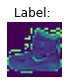

In [18]:
for X in X_train:
    print(X.shape)
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.title('Label: ')
    img = np.uint8(255*X[:,:,0])
    plt.imshow(img)
    break

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


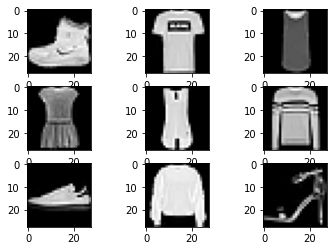

In [19]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot
from keras.datasets import fashion_mnist
# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [20]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalizing the data to help with the training
X_train /= 255
X_test /= 255


In [21]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


# 1 C+P (Bench Mark)

In [22]:
# Basic CNN Model with 1 (C+P)
#Basic Parameters for the CNN Function

filter_no=50   #Number of Filters in the Network
stride=(1,1)   # Strides (1,1) and (2,2) etc
padding_type='valid'  #Padding type valid or same
act_fn='relu'       #Activation function Relu and Leaky Relu etc
polsize=(2,2)         #Pooling size   (2,2)  or (3,3) etc
drop_out=0.25     # Dropout rate, change to 0 if no dropout
bachnorm='Yes'     # bachnormalization eitherr yes and No
layer2='No'        # Second CNN layer eitherr yes and No
input_shp=(28, 28, 1)   # X shape
output_class=10          # Number of classes in output vector
label=[0, 1, 2, 3, 4,5,6,7,8,9]        #Labels for output classes

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 50)        500       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8450)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 500)               4225500   
_________________________________________________________________
dropout_38 (Dropout)         (None, 500)              

#### Benchmark Framework
Here, we have considered the benchmark model with one convolution + pooling (C+P) layer and then fully connected Neural Network. Running the model in the test harness first prints the classification accuracy on the test dataset. The results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome. The model has 4,353,760 number of parameters.

In this case, we can see that the model achieved a classification accuracy of just less than 92%. The accuracy of individual classes varies in the range of 87 to 98%. The precision and recall are reasonable and vary in the range of 85 to 100%. The overall Loss is

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186


This is the benchmark framework, and we compare the different framework with additional layers and hyperparameter tuning with this.


### 1) what effect does increasing to 2 (C+P) layers has on the performance?

Here we increase the number of CNN layers in the network from 1 to 2. All other parameters are same to the 1 (C+P) CNN but we include the 2 CNN layer. Layer2 is changed from 'No' to 'Yes'.


In [23]:
#Basic Parameters are same to CNN 1(C+P) but layer2 is changed from 'No' to 'Yes' 
filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='Yes'           # Changed from 'No' to 'Yes'
input_shp=(28, 28, 1)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 50)        500       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 8450)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 500)               4225500   
_________________________________________________________________
dropout_42 (Dropout)         (None, 500)             

Here we have considered the two convolution + pooling 2(C+P) layer and then fully connected network. All All other parameters are same to the 1 (C+P) CNN but we include the 2 CNN layer. Layer 2 is changed from 'No' to 'Yes'. The number of parameters is 4,353,760.

The results show that the overall accuracy is about 69%. With 10 epoches the loss is

loss: 0.1779 - accuracy: 0.9327 - val_loss: 0.2310 - val_accuracy: 0.9209


The accuracy of individual classes vary in the range of 87 to 99%. The precision and recall are reasonable and vary in the range of 87 to 98%. The results indicate that with the addition of second (C+P) the results in terms of precision, recall and loss improve a bit, but not as much which were expected. The second (C+P) layer does not improve the results significantly.

Loss in case of 2 (C+P)

loss: 0.1779 - accuracy: 0.9327 - val_loss: 0.2310 - val_accuracy: 0.9209

Loss in case of 1 (C+P)- Benchmark

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186

Increasing the number of hidden layers might improve the accuracy or might not, it really depends on the complexity of the problem that you are trying to solve. Where in the left picture they try to fit a linear function to the data By adding more layers and more units within a layer, a deep network can represent functions of increasing complexity. Traditionally, it has been challenging to train neural network models with more than a few layers due to problems such as vanishing gradients. Depending upon how large your dataset is, the CNN architecture is implemented. Adding layers unnecessarily to any CNN will increase your number of parameters only for the smaller dataset, say in 1000s (total 1000). It’s true for some reasons that on adding more hidden layers, it will give more accuracy. This is true for larger datasets, as more layers with less stride factor will extract more features for your input data. In CNN, how you play with your architecture is completely dependent on what your requirement is and how your data is. There is term called “Overfitting” and “Underfitting”. Increasing Unnecessary parameters will only overfit your network. Say, when you are classifying between the two fruits, take apple and grapes. What can be the possible features that can distinguish only on the basis of visual features. It may be their edges, curves, shape, color, number of seeds inside. But if we give the smell factor to it. Will the machine be able to distinguish the two fruits without using any sensor? The answer is clearly “No”. So, providing this unnecessary smell factor, will not only increase your parameters but will also affect your accuracy. So, this is the example of Overfitting.

### 2) What happens to performance when I add and remove dropout? (Use 1 C+P)

Here, we use the basic parameters used in CNN 1(C+P) but change the dropout. we change the dropout from 0.25 to 0.0 (means no dropout). All other parameters are same to the 1 (C+P) CNN.

In [24]:
#Basic Parameters are same to CNN 1(C+P) but dropout is changed from 0.25 to 0.0 
filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.0     #changed from 0.25 to 0
bachnorm='Yes'     
layer2='No'
input_shp=(28, 28, 1)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 50)        500       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 8450)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 500)               4225500   
_________________________________________________________________
dropout_46 (Dropout)         (None, 500)             

Here we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the dropout from 0.25 to 0.0 (means no dropout). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 4,353,760.

The results show that the overall accuracy is about 93%. With 10 epochs the loss is about 

loss: 0.1292 - accuracy: 0.9517 - val_loss: 0.2445 - val_accuracy: 0.9194


The accuracy of individual classes varies in the range of 77 to 99. The precision and recall are reasonable and vary in the range of 77 to 100%.

The results indicate that with no dropout the results in terms of accuracy, loss, precision, and recall becomes a bit worsen as compared to the benchmark model (1(C+P) with the dropout of 0.25). The loss comparison shows that

Loss in case of dropout==0.00

loss: 0.1779 - accuracy: 0.9327 - val_loss: 0.2310 - val_accuracy: 0.9209

Loss in case of dropout==0.25- Benchmark

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186


The Dropout is used to prevent the model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase. With dropout (dropout rate less than some small value), the accuracy will gradually increase, and loss will gradually decrease first (That is what is happening in your case). When you increase dropout beyond a certain threshold, it results in the model not being able to fit properly. Usually, dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus, they're likely to excessively co-adapting themselves causing overfitting. However, since it's a stochastic regularization technique, you can really place it everywhere.


### 3) What happens to performance when I add and remove Batch Normalization? (Use 1 C+P)

Here, we use the basic parameters used in CNN 1(C+P) but change the Batch Normalization. we change the Batch Normalization (bachnorm) from 'yes' to 'No' (means no Batch Normalization). All other parameters are same to the 1 (C+P) CNN.

In [25]:
#Basic Parameters are same to CNN 1(C+P) but Batch Normalization (bachnorm) is changed from 'yes' to 'No'
filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25    
bachnorm='No'     #changed from yes and No
layer2='No'
input_shp=(28, 28, 1)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 50)        500       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 8450)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 500)               4225500   
_________________________________________________________________
dropout_50 (Dropout)         (None, 500)             

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the Batch Normalization (bachnorm) from 'yes' to 'No' (means no Batch Normalization). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 4,353,760.

The results show that the overall accuracy is about 92%. With 10 epochs the loss is about 0.9185.

loss: 0.1787 - accuracy: 0.9333 - val_loss: 0.2290 - val_accuracy: 0.9185

The accuracy of individual classes varies in the range of 88 to 99%. The precision and recall are reasonable and vary in the range of 77 to 98%. The loss comparison shows that

Loss in case with No Batch Normalization

loss: 0.1787 - accuracy: 0.9333 - val_loss: 0.2290 - val_accuracy: 0.9185

Loss in case Batch Normalization- Benchmark

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186

The results indicate that with no batch normalization the prediction performance improves in terms of accuracy, loss, precision, and recall becomes a bit worsen as compared to the benchmark model (1 C+P) with batch normalization). When i remove batch normalization i see that loss is going to decrease and the accuracy of model increased up to sufficient number which i think is good in case of CNN, because we have to obtain high performance with high accuracy to get the detection of any object clearly

### 4) What happens to performance when I use valid and same paddings? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the Paddings. we change the Paddings (padding_type) from 'valid' to 'same'. All other parameters are same to the 1 (C+P) CNN.

In [26]:
#Basic Parameters are same to CNN 1(C+P) but Padding is changed from 'Valid' to 'Same'
filter_no=50   
stride=(1,1)   
padding_type='same'  #changed fro valid to same
act_fn='relu'      
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='No'
input_shp=(28, 28, 1)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 50)        500       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 50)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 14, 14, 50)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 14, 14, 50)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 9800)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 500)               4900500   
_________________________________________________________________
dropout_54 (Dropout)         (None, 500)             

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the Paddings (padding_type) from 'valid' to 'same'. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 5,028,760.

The results show that there is no significant change in outcome. The overall accuracy is about 91% a bit smaller to the one we have in valid padding. With 10 epochs the loss is about 0.91, which is a bit higher than the one obtained in case of valid padding.

loss: 0.1720 - accuracy: 0.9361 - val_loss: 0.2390 - val_accuracy: 0.9139

The accuracy of individual classes varies in the range of 58 to 80%. The precision and recall are reasonable and vary in the range of 48 to 85%. The results indicate that there is no significant change in the performance of Neural Network with changing the padding type. The minor change in result may be due to the change in split of test and training data and epochs.

The Same Padding applies padding to the input image so that the input image gets fully covered by the filter and specified stride. It is called SAME because, for stride 1, the output will be the same as the input. The loss comparison shows that

Loss in case of Same Padding

loss: 0.1720 - accuracy: 0.9361 - val_loss: 0.2390 - val_accuracy: 0.9139

Loss in case of Valid Padding (Benchmark)

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186

### 5) What happens to performance when I increase number of filters? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the number the filter (increase the number of filters). we change the number of filters (filter_no) from 50 to 75. All other parameters are same to the 1 (C+P) CNN.

In [27]:
#Basic Parameters are same to CNN 1(C+P) but change the number of filters (filter_no) from 50 to 75
filter_no=75   # changed from 50 to 75
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='No'
input_shp=(28, 28, 1)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 75)        750       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 75)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 13, 13, 75)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 13, 13, 75)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 12675)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 500)               6338000   
_________________________________________________________________
dropout_58 (Dropout)         (None, 500)             

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the number of filters (filter_no) from 50 to 75. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 6,466,510.

The results show that there is no significant change in outcome. The overall accuracy is about 92% a bit higher than the one we have in case of filter number is equal to 50. With 10 epochs the loss is about 0.23, which is a significantly smaller than the one obtained in case of 50 filters.

loss: 0.1639 - accuracy: 0.9379 - val_loss: 0.2351 - val_accuracy: 0.9198

The accuracy of individual classes varies in the range of 76 to 99%. The precision and recall are reasonable and vary in the range of 89 to 100%. The results indicate that there is significant change in the performance of Neural Network with changing the number of filters. The accuracy has improved, and the loss has fallen.

Loss with filter number==75

loss: 0.1639 - accuracy: 0.9379 - val_loss: 0.2351 - val_accuracy: 0.9198

Loss with filter number==50, (Benchmark)

loss: 0.1639 - accuracy: 0.9379 - val_loss: 0.2351 - val_accuracy: 0.9198

### 6) What happens to performance when I use different pooling sizes? (Use 1 C+P and total 2 filter sizes only)

Here, we use the basic parameters as used in CNN 1(C+P) but change the pooling size (polsize). we change the pooling size (polsize) from (2,2) to (3,3). All other parameters are same to the 1 (C+P) CNN.

In [28]:
#Basic Parameters are same to CNN 1(C+P) but change the pooling size (polsize) from (2,2) to (3,3)

filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='relu'       
polsize=(3,3)         # changed from (2,2) to (3,3)
drop_out=0.25     
bachnorm='Yes'     
layer2='No'
input_shp=(28, 28, 1)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 50)        500       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 8, 8, 50)          0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 8, 8, 50)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 500)               1600500   
_________________________________________________________________
dropout_62 (Dropout)         (None, 500)             

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the pooling size (polsize) from (2,2) to (3,3). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 1,728,760.

The addition of a pooling layer after the convolutional layer is a common pattern used for ordering layers within a convolutional neural network that may be repeated one or more times in a given model. The pooling layer operates upon each feature map separately to create a new set of the same number of pooled feature maps. Pooling involves selecting a pooling operation, much like a filter to be applied to feature maps. The size of the pooling operation or filter is smaller than the size of the feature map; specifically, it is almost always 2×2 pixels applied with a stride of 2 pixels.

This means that the pooling layer will always reduce the size of each feature map by a factor of 2, e.g., each dimension is halved, reducing the number of pixels or values in each feature map to one quarter the size. 

The results show that there is significant change in outcome. The overall accuracy is about 91%, a bit smaller than the one we have in case of pooling size (polsize) is (2,2). With 10 epochs the loss is about 0.8625, which is a significantly smaller than the one obtained in case of 50 filters.

loss: 0.2360 - accuracy: 0.9103 - val_loss: 0.2526 - val_accuracy: 0.9057

The accuracy of individual classes varies in the range of 85 to 98%. The precision and recall are reasonable and vary in the range of 81 to 100%. The results indicate that there is significant change in the performance of Neural Network with changing the pooling size (polsize) from (2,2) to (3,3). The accuracy as well as the precision/recall has improved, and the loss has fallen.

Loss with Pooling size (polsize) is (3,3)

loss: 0.2360 - accuracy: 0.9103 - val_loss: 0.2526 - val_accuracy: 0.9057

Loss with Pooling size (polsize) is (2,2), (Benchmark)

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186

### 7) Is there a difference in performance if I use ReLU or Leaky Relu? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the activation function (act_fn). we change the activation function (act_fn) from ReLU to Leaky Relu. All other parameters are same to the 1 (C+P) CNN.

In [29]:
#Basic Parameters are same to CNN 1(C+P) but change the activation function (act_fn) from ReLU to Leaky Relu

filter_no=50   
stride=(1,1)   
padding_type='valid'  
act_fn='leaky_relu'       #changed from relu to leaky_relu
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'    
layer2='No'
input_shp=(28, 28, 1)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 50)        500       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 8450)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 500)               4225500   
_________________________________________________________________
dropout_66 (Dropout)         (None, 500)             

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the activation function (act_fn) from ReLU to Leaky Relu. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 4,353,760.

The results show that there is no significant change in outcome. The overall accuracy is about 91%, a bit smaller than the one we have in case of ReLU activation function. With 10 epochs the loss is about 0.8849, which is a significantly higher than the one obtained in case of ReLU activation function.

loss: 0.2057 - accuracy: 0.9226 - val_loss: 0.2423 - val_accuracy: 0.9131

The accuracy of individual classes varies in the range of 86 to 99. The precision and recall are reasonable and vary in the range of 73 to 99%. The results indicate that there is no significant change in the performance of Neural Network with changing the activation function from ReLU to Leaky Relu. The accuracy as well as the precision/recall is almost similar, however the loss has increased a bit.

The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time. Let's look at the gradient of the ReLU function. Due to this, during the backpropagation process, the weights and biases for some neurons are not updated. The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better. The rectified linear activation is the default activation when developing multilayer Perceptron and convolutional neural networks.

Adoption of ReLU may easily be considered one of the few milestones in the deep learning revolution, e.g. the techniques that now permit the routine development of very deep neural networks.

The function is linear for values greater than zero, meaning it has a lot of the desirable properties of a linear activation function when training a neural network using backpropagation. Yet, it is a nonlinear function as negative values are always output as zero.

There’s come some difference when I used both ReLU and leaky ReLU , and this also making sense that it must be different when using both, and the result I obtained is given below:

Loss with Leaky Relu activation function (act_fn)

loss: 0.2057 - accuracy: 0.9226 - val_loss: 0.2423 - val_accuracy: 0.9131

Loss with Relu activation function (act_fn), (Benchmark)

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186

### 8) Is there a difference in performance if I change stride from 1 to 2? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the strides (stride). we change the strides (stride) from (1,1) to (2,2). All other parameters are same to the 1 (C+P) CNN.

In [30]:
#Basic Parameters are same to CNN 1(C+P) but change the strides (stride) from (1,1) to (2,2)

filter_no=50   
stride=(1,1)   #changed from (1,1) to (2,2)
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='No'
input_shp=(28, 28, 1)
output_class=10
label=[0, 1, 2, 3, 4,5,6,7,8,9]

 #CNN Function Call 
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, layer2,output_class,label)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 50)        500       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 8450)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 500)               4225500   
_________________________________________________________________
dropout_70 (Dropout)         (None, 500)             

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the strides (stride) from (1,1) to (2,2). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 4,353,760.

The results show that there is no significant change in outcome. The overall accuracy is about 92%, a bit smaller than the one we have in case of strides of (1,1). With 10 epochs the loss is about 0.24, which is a significantly higher than the one obtained in case of strides of (1,1). The loss results shows 

loss: 0.1748 - accuracy: 0.9342 - val_loss: 0.2428 - val_accuracy: 0.9150

The accuracy of individual classes varies in the range of 85 to 99%. The precision and recall are reasonable and vary in the range of 80% to 99%. The results indicate that there is no significant change in the performance of Neural Network with changing the strides from (1,1) to (2,2) interms of overall accuracy. However, the loss has increased significantly with the fall in precision and recall rate. The loss function comparison shows that

Loss with stride (2,2)

loss: 0.1748 - accuracy: 0.9342 - val_loss: 0.2428 - val_accuracy: 0.9150

Loss with with stride (1,1), (Benchmark)

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186

Stride controls how the filter convolves around the input volume. In the example we had in part 1, the filter convolves around the input volume by shifting one unit at a time. The amount by which the filter shifts is the stride. ... Stride is normally set in a way so that the output volume is an integer and not a fraction

In several cases, we incorporate techniques, including padding and stride convolutions, that affect the size of the output. As motivation, note that since kernels generally have width and height greater than 1, after applying many successive convolutions, we tend to wind up with outputs that are considerably smaller than our input. If we start with a 240×240-pixel image, 10 layers of 5×5 convolutions reduce the image to 200×200 pixels, slicing off 30% of the image and with it obliterating any interesting information on the boundaries of the original image. Padding is the most popular tool for handling this issue.

The default stride or strides in two dimensions is (1,1) for the height and the width movement, performed when needed. And this default works well in most cases.

The stride can be changed, which has an effect both on how the filter is applied to the image and, in turn, the size of the resulting feature map. For example, the stride can be changed to (2,2). This has the effect of moving the filter two pixels right for each horizontal movement of the filter and two pixels down for each vertical movement of the filter when creating the feature map.

# Dataset 3: Real and Fake Face Detection

In this replository is a small application that uses a CNN to predict real or fake face.

Data has been collected from kaggle. For training ~1450 images and with an additional ~300 images for validation.

Found 1437 images belonging to 2 classes.
Found 604 images belonging to 2 classes.

First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [31]:
###Training
#renaming real and fake directories
real_t = "C:\\Users\\waliullah\\Desktop\\DL\Assignment 2\\real-and-fake-face-detection-master\\dataset\\training\\real"
fake_t = "C:\\Users\\waliullah\\Desktop\\DL\Assignment 2\\real-and-fake-face-detection-master\\dataset\\training\\fake"
#we're creating a list of real and fake images
real_path_t = os.listdir(real_t)
fake_path_t = os.listdir(fake_t)

#Test

real_s = "C:\\Users\\waliullah\\Desktop\\DL\Assignment 2\\real-and-fake-face-detection-master\\dataset\\test\\real"
fake_s = "C:\\Users\\waliullah\\Desktop\\DL\Assignment 2\\real-and-fake-face-detection-master\\dataset\\test\\fake"
#we're creating a list of real and fake images
real_path_s = os.listdir(real_s)
fake_path_s = os.listdir(fake_s)

nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:\\Users\\waliullah\\Desktop\DL\\Assignment 2\\dataset\\training',
                                                 target_size=(128,128),
                                                 batch_size =nbatch,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('C:\\Users\\waliullah\\Desktop\\DL\Assignment 2\\dataset\\test',
                                            target_size=(128,128),
                                            batch_size =nbatch,
                                            class_mode = 'binary')

Found 1437 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


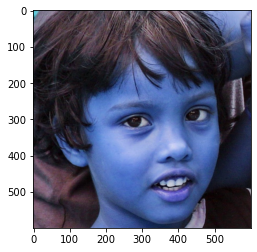

In [32]:
plt.imshow(cv2.imread(os.path.join(real_t, real_path_t[0])))

Text(0.5, 0, 'Class')

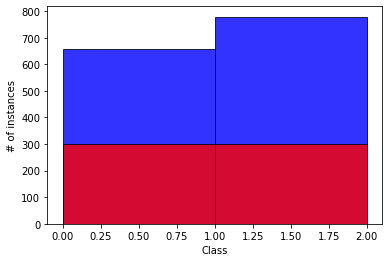

In [33]:
# Number of Real and Fake Faces in Training and Test data set

h1 = plt.hist(training_set.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

(128, 128, 128, 3) (128,)


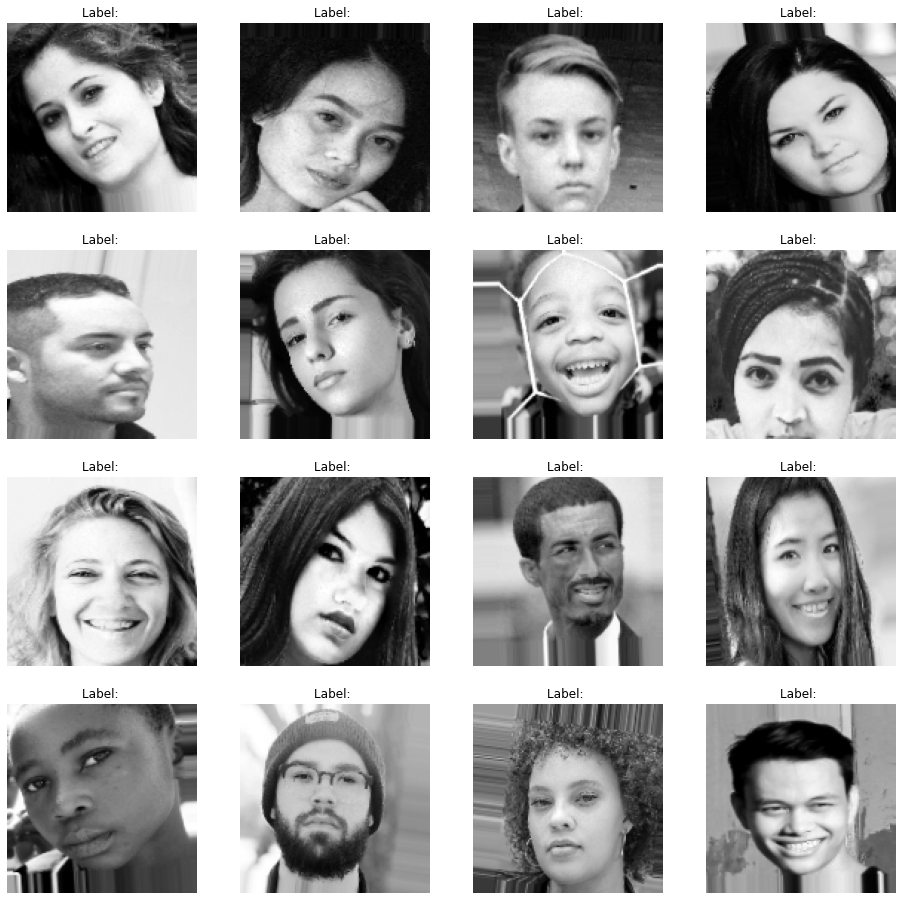

In [34]:
#some pictures from training set
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

In [35]:
#Number of print('Training Set Real:',len(real_path_s))
print('Training Set Fake:',len(fake_path_s))
print('Test Set Real:',len(real_path_t))
print('Test Set Fake:',len(fake_path_t))

Training Set Fake: 302
Test Set Real: 779
Test Set Fake: 658


In [36]:
img_size = int(128)
def create_training_data():
    training_data = []
    y=[]
    for img in tqdm(real_path_t[:981]):
        path = os.path.join(real_t, img)
#         label = [1] 
        image = cv2.resize( cv2.imread(path), (img_size,img_size) )
        training_data.append(np.array(image))
        y.append(1)
        
    for img in tqdm(fake_path_t[:860]):
        path = os.path.join(fake_t, img)
#         label = [0] 
        image = cv2.resize(cv2.imread(path), (img_size,img_size))
        training_data.append(np.array(image))  
        y.append(0)
        
    return(training_data,y)

def create_test_data():
    test_data = []
    output_data=[]
    for img in tqdm(real_path_s[:981]):
        path = os.path.join(real_s, img)
        image = cv2.resize( cv2.imread(path), (img_size,img_size) )
        
        test_data.append(np.array(image))
        output_data.append(1)
        
    for img in tqdm(fake_path_s[:860]):
        path = os.path.join(fake_s, img)
        image = cv2.resize(cv2.imread(path), (img_size,img_size))
        
        test_data.append(np.array(image))
        output_data.append(0)

    return(test_data,output_data)

    

X_train,Y_train = create_training_data()
X_test,Y_test= create_test_data()

100%|██████████| 302/302 [00:03<00:00, 81.53it/s]


In [37]:
l=list(zip(X_train,Y_train))
shuffle(l)
X_train,Y_train=zip(*l)


In [38]:
X_train=np.array(X_train)

Y_train =np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)


In [39]:
# # building the input vector from the 32x32 pixels
#X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
#X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [40]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 2
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (1437,)
Shape after one-hot encoding:  (1437, 2)


# 1 C+P (Bench Mark)

In [41]:
# Basic CNN Model with 1 (C+P)

#Basic Parameters for the CNN Function

filter_no=50   #Number of Filters in the Network
stride=(1,1)   # Strides (1,1) and (2,2) etc
padding_type='valid'  #Padding type valid or same
act_fn='relu'       #Activation function Relu and Leaky Relu etc
polsize=(2,2)         #Pooling size   (2,2)  or (3,3) etc
drop_out=0.25     # Dropout rate, change to 0 if no dropout
bachnorm='Yes'     # bachnormalization eitherr yes and No
layer2='No'        # Second CNN layer eitherr yes and No
input_shp=(128, 128, 3)      ## X shape (32, 32, 3)

output_class=2       # Number of classes in output vector
label=[0, 1]          #Labels for output classes

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 50)      1400      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 63, 63, 50)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 198450)            0         
_________________________________________________________________
dense_54 (Dense)             (None, 500)               99225500  
_________________________________________________________________
dropout_74 (Dropout)         (None, 500)             

#### Benchmark Framework

Here, we have considered the benchmark model with one convolution + pooling (C+P) layer and then fully connected Neural Network. Running the model in the test harness first prints the classification accuracy on the test dataset. The results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome. The model has 99,352,652 number of parameters.

In this case, we can see that the model achieved a classification accuracy of just less than 65%. The precision and recall are reasonable and vary in the range of 62 to 68%. The overall Loss is

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

This is the benchmark framework, and we compare the different framework with additional layers and hyperparameter tuning with this.


### 1) what effect does increasing to 2 (C+P) layers has on the performance?

Here we increase the number of CNN layers in the network from 1 to 2. All other parameters are same to the 1 (C+P) CNN but we include the 2 CNN layer. Layer2 is changed from 'No' to 'Yes'


In [42]:
#Basic Parameters are same to CNN 1(C+P) but layer2 is changed from 'No' to 'Yes' 

filter_no=50   
stride=(1,1) 
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25     
bachnorm='Yes'     
layer2='Yes'                          # Changed from 'No' to 'Yes'     
input_shp=(128, 128, 3)      

output_class=2       
label=[0, 1]          

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 126, 126, 50)      1400      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 63, 63, 50)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 198450)            0         
_________________________________________________________________
dense_57 (Dense)             (None, 500)               99225500  
_________________________________________________________________
dropout_78 (Dropout)         (None, 500)             

Here we have considered the two convolution + pooling 2(C+P) layer and then fully connected network. All All other parameters are same to the 1 (C+P) CNN but we include the 2 CNN layer. Layer 2 is changed from 'No' to 'Yes'. The number of parameters is 99,352,652.

The results show that the overall accuracy is about 58%. With 10 epoches the loss is

loss: 0.2456 - accuracy: 0.9109 - val_loss: 0.9009 - val_accuracy: 0.5828

The accuracy of individual classes vary in the range of 64 to 66%. The precision and recall are reasonable and vary in the range of 64 to 68%. The results indicate that with the addition of second (C+P) the results in terms of precision, recall and loss improve a bit, but not as much which were expected. The second (C+P) layer does not improve the results significantly.

Loss in case of 2 (C+P)

loss: 0.2456 - accuracy: 0.9109 - val_loss: 0.9009 - val_accuracy: 0.5828

Loss in case of 1 (C+P)- Benchmark

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

Increasing the number of hidden layers might improve the accuracy or might not, it really depends on the complexity of the problem that you are trying to solve. Where in the left picture they try to fit a linear function to the data By adding more layers and more units within a layer, a deep network can represent functions of increasing complexity. Traditionally, it has been challenging to train neural network models with more than a few layers due to problems such as vanishing gradients. Depending upon how large your dataset is, the CNN architecture is implemented. Adding layers unnecessarily to any CNN will increase your number of parameters only for the smaller dataset, say in 1000s (total 1000). It’s true for some reasons that on adding more hidden layers, it will give more accuracy. This is true for larger datasets, as more layers with less stride factor will extract more features for your input data. In CNN, how you play with your architecture is completely dependent on what your requirement is and how your data is. There is term called “Overfitting” and “Underfitting”. Increasing Unnecessary parameters will only overfit your network. Say, when you are classifying between the two fruits, take apple and grapes. What can be the possible features that can distinguish only on the basis of visual features. It may be their edges, curves, shape, color, number of seeds inside. But if we give the smell factor to it. Will the machine be able to distinguish the two fruits without using any sensor? The answer is clearly “No”. So, providing this unnecessary smell factor, will not only increase your parameters but will also affect your accuracy. So, this is the example of Overfitting.

### 2) What happens to performance when I add and remove dropout? (Use 1 C+P)

Here, we use the basic parameters used in CNN 1(C+P) but change the dropout. we change the dropout from 0.25 to 0.0 (means no dropout). All other parameters are same to the 1 (C+P) CNN.

In [43]:
#Basic Parameters are same to CNN 1(C+P) but dropout is changed from 0.25 to 0.0 
filter_no=50   
stride=(1,1)  
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.0                 #changed from 0.25 to 0    
bachnorm='Yes'     
layer2='No'                             
input_shp=(128, 128, 3)      

output_class=2       
label=[0, 1]          

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 126, 50)      1400      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 63, 63, 50)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 198450)            0         
_________________________________________________________________
dense_60 (Dense)             (None, 500)               99225500  
_________________________________________________________________
dropout_82 (Dropout)         (None, 500)             

Here we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the dropout from 0.25 to 0.0 (means no dropout). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 99,352,652.

The results show that the overall accuracy is about 65%. With 10 epochs the loss is about

loss: 0.5622 - accuracy: 0.7293 - val_loss: 0.6364 - val_accuracy: 0.6540

The accuracy of individual classes varies in the range of 65 to 66%. The precision and recall are reasonable and vary in the range of 62 to 68%.

The results indicate that with no dropout the results in terms of accuracy, loss, precision, and recall becomes a bit worsen as compared to the benchmark model (1(C+P) with the dropout of 0.25). The loss comparison shows that

Loss in case of dropout==0.00

loss: 0.5622 - accuracy: 0.7293 - val_loss: 0.6364 - val_accuracy: 0.6540

Loss in case of dropout==0.25- Benchmark

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

The Dropout is used to prevent the model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase. With dropout (dropout rate less than some small value), the accuracy will gradually increase, and loss will gradually decrease first (That is what is happening in your case). When you increase dropout beyond a certain threshold, it results in the model not being able to fit properly. Usually, dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus, they're likely to excessively co-adapting themselves causing overfitting. However, since it's a stochastic regularization technique, you can really place it everywhere.

### 3) What happens to performance when I add and remove Batch Normalization? (Use 1 C+P)

Here, we use the basic parameters used in CNN 1(C+P) but change the Batch Normalization. we change the Batch Normalization (bachnorm) from 'yes' to 'No' (means no Batch Normalization). All other parameters are same to the 1 (C+P) CNN.

In [44]:
#Basic Parameters are same to CNN 1(C+P) but Batch Normalization (bachnorm) is changed from 'yes' to 'No'

filter_no=50   
stride=(1,1) 
padding_type='valid'  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25                   
bachnorm='No'                #changed from yes and No
layer2='No'                             
input_shp=(128, 128, 3)      

output_class=2       
label=[0, 1]          

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 126, 126, 50)      1400      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 63, 63, 50)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 198450)            0         
_________________________________________________________________
dense_63 (Dense)             (None, 500)               99225500  
_________________________________________________________________
dropout_86 (Dropout)         (None, 500)             

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the Batch Normalization (bachnorm) from 'yes' to 'No' (means no Batch Normalization). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 99,352,652.

The results show that the overall accuracy is about 63%. With 10 epochs the loss is about 0.6411.

loss: 0.5492 - accuracy: 0.7196 - val_loss: 0.6385 - val_accuracy: 0.6258

The accuracy of individual classes varies in the range of 64 to 66%. The precision and recall are reasonable and vary in the range of 62 to 68%. The loss comparison shows that

Loss in case with No Batch Normalization

loss: 0.5492 - accuracy: 0.7196 - val_loss: 0.6385 - val_accuracy: 0.6258

Loss in case Batch Normalization- Benchmark

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

The results indicate that with no batch normalization the prediction performance improves in terms of accuracy, loss, precision, and recall becomes a bit worsen as compared to the benchmark model (1 C+P) with batch normalization). When i remove batch normalization i see that loss is going to decrease and the accuracy of model increased up to sufficient number which i think is good in case of CNN, because we have to obtain high performance with high accuracy to get the detection of any object clearly.

### 4) What happens to performance when I use valid and same paddings? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the Paddings. we change the Paddings (padding_type) from 'valid' to 'same'. All other parameters are same to the 1 (C+P) CNN.

In [45]:
#Basic Parameters are same to CNN 1(C+P) but Padding is changed from 'Valid' to 'Same'

filter_no=50   
stride=(1,1)   
padding_type='same'  #changed fro valid to same  
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25                   
bachnorm='Yes'        
layer2='No'                             
input_shp=(128, 128, 3)      

output_class=2       
label=[0, 1]          

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 128, 128, 50)      1400      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 50)        0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 64, 64, 50)        0         
_________________________________________________________________
dropout_89 (Dropout)         (None, 64, 64, 50)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 204800)            0         
_________________________________________________________________
dense_66 (Dense)             (None, 500)               102400500 
_________________________________________________________________
dropout_90 (Dropout)         (None, 500)             

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the Paddings (padding_type) from 'valid' to 'same'. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 102,527,652.

The results show that there is no significant change in outcome. The overall accuracy is about 57% a bit smaller to the one we have in valid padding. With 10 epochs the loss is about 0.8986, which is a bit higher than the one obtained in case of valid padding.

loss: 0.2966 - accuracy: 0.8873 - val_loss: 0.8986 - val_accuracy: 0.5662

The accuracy of individual classes varies in the range of 64 to 66%. The precision and recall are reasonable and vary in the range of 62 to 68%. The results indicate that there is no significant change in the performance of Neural Network with changing the padding type. The minor change in result may be due to the change in split of test and training data and epochs.

The Same Padding applies padding to the input image so that the input image gets fully covered by the filter and specified stride. It is called SAME because, for stride 1, the output will be the same as the input. The loss comparison shows that

Loss in case of Same Padding

loss: 0.2966 - accuracy: 0.8873 - val_loss: 0.8986 - val_accuracy: 0.5662

Loss in case of Valid Padding (Benchmark)

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

### 5) What happens to performance when I increase number of filters? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the number the filter (increase the number of filters). we change the number of filters (filter_no) from 50 to 75. All other parameters are same to the 1 (C+P) CNN.

In [46]:
#Basic Parameters are same to CNN 1(C+P) but change the number of filters (filter_no) from 50 to 75
filter_no=75   # changed from 50 to 75
stride=(1,1)   
padding_type='valid'    
act_fn='relu'       
polsize=(2,2)         
drop_out=0.25                   
bachnorm='Yes'        
layer2='No'                             
input_shp=(128, 128, 3)      

output_class=2       
label=[0, 1]          

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 126, 126, 75)      2100      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 63, 63, 75)        0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 63, 63, 75)        0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 63, 63, 75)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 297675)            0         
_________________________________________________________________
dense_69 (Dense)             (None, 500)               148838000 
_________________________________________________________________
dropout_94 (Dropout)         (None, 500)             

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the number of filters (filter_no) from 50 to 75. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 148,965,852.

The results show that there is no significant change in outcome. The overall accuracy is about 58% a bit smaller than the one we have in case of filter number is equal to 50. With 10 epochs the loss is about 0.23, which is a significantly smaller than the one obtained in case of 50 filters.

loss: 0.3371 - accuracy: 0.8678 - val_loss: 0.8640 - val_accuracy: 0.5795

The accuracy of individual classes varies in the range of 64 to 66%. The precision and recall are reasonable and vary in the range of 62 to 68%. The results indicate that there is significant change in the performance of Neural Network with changing the number of filters. The accuracy has improved, and the loss has fallen.

Loss with filter number==75

loss: 0.3371 - accuracy: 0.8678 - val_loss: 0.8640 - val_accuracy: 0.5795

Loss with filter number==50, (Benchmark)

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

### 6) What happens to performance when I use different pooling sizes? (Use 1 C+P and total 2 filter sizes only)

Here, we use the basic parameters as used in CNN 1(C+P) but change the pooling size (polsize). we change the pooling size (polsize) from (2,2) to (3,3). All other parameters are same to the 1 (C+P) CNN.

In [47]:
#Basic Parameters are same to CNN 1(C+P) but change the pooling size (polsize) from (2,2) to (3,3)
filter_no=50   
stride=(1,1)  
padding_type='valid'   
act_fn='relu'       
polsize=(3,3)         # changed from (2,2) to (3,3)        
drop_out=0.25                   
bachnorm='Yes'        
layer2='No'                             
input_shp=(128, 128, 3)      

output_class=2       
label=[0, 1]          

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 126, 126, 50)      1400      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 42, 42, 50)        0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 42, 42, 50)        0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 42, 42, 50)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 88200)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 500)               44100500  
_________________________________________________________________
dropout_98 (Dropout)         (None, 500)             

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the pooling size (polsize) from (2,2) to (3,3). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 44,227,652.

The addition of a pooling layer after the convolutional layer is a common pattern used for ordering layers within a convolutional neural network that may be repeated one or more times in a given model. The pooling layer operates upon each feature map separately to create a new set of the same number of pooled feature maps. Pooling involves selecting a pooling operation, much like a filter to be applied to feature maps. The size of the pooling operation or filter is smaller than the size of the feature map; specifically, it is almost always 2×2 pixels applied with a stride of 2 pixels.

This means that the pooling layer will always reduce the size of each feature map by a factor of 2, e.g., each dimension is halved, reducing the number of pixels or values in each feature map to one quarter the size.

The results show that there is significant change in outcome. The overall accuracy is about 63%, a bit smaller than the one we have in case of pooling size (polsize) is (2,2). With 10 epochs the loss is about 0.8625, which is a significantly smaller than the one obtained in case of 50 filters.

loss: 0.5626 - accuracy: 0.7418 - val_loss: 0.6634 - val_accuracy: 0.6341

The accuracy of individual classes varies in the range of 61 to 65%. The precision and recall are reasonable and vary in the range of 62 to 69%. The results indicate that there is significant change in the performance of Neural Network with changing the pooling size (polsize) from (2,2) to (3,3). The accuracy as well as the precision/recall has improved, and the loss has fallen.

Loss with Pooling size (polsize) is (3,3)

loss: 0.5626 - accuracy: 0.7418 - val_loss: 0.6634 - val_accuracy: 0.6341

Loss with Pooling size (polsize) is (2,2), (Benchmark)

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

### 7) Is there a difference in performance if I use ReLU or Leaky Relu? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the activation function (act_fn). we change the activation function (act_fn) from ReLU to Leaky Relu. All other parameters are same to the 1 (C+P) CNN.

In [48]:
#Basic Parameters are same to CNN 1(C+P) but change the activation function (act_fn) from ReLU to Leaky Relu

filter_no=50   
stride=(1,1)   
padding_type='valid'   
act_fn='leaky_relu'       #changed from relu to leaky_relu      
polsize=(2,2)                
drop_out=0.25                   
bachnorm='Yes'        
layer2='No'                             
input_shp=(128, 128, 3)      

output_class=2       
label=[0, 1]          

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 50)      1400      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 63, 63, 50)        0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 63, 63, 50)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 198450)            0         
_________________________________________________________________
dense_75 (Dense)             (None, 500)               99225500  
_________________________________________________________________
dropout_102 (Dropout)        (None, 500)             

Here, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the activation function (act_fn) from ReLU to Leaky Relu. All other parameters are same to the 1 (C+P) CNN. The number of parameters is 99,352,652.

The results show that there is no significant change in outcome. The overall accuracy is about 91%, a bit smaller than the one we have in case of ReLU activation function. With 10 epochs the loss is about 0.8849, which is a significantly higher than the one obtained in case of ReLU activation function.

loss: 0.4149 - accuracy: 0.8142 - val_loss: 0.7267 - val_accuracy: 0.6175

The accuracy of individual classes varies in the range of 53 to 68%. The precision and recall are reasonable and vary in the range of 43 to 69%. The results indicate that there is no significant change in the performance of Neural Network with changing the activation function from ReLU to Leaky Relu. The accuracy as well as the precision/recall is almost similar, however the loss has increased a bit.

The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time. Let's look at the gradient of the ReLU function. Due to this, during the backpropagation process, the weights and biases for some neurons are not updated. The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better. The rectified linear activation is the default activation when developing multilayer Perceptron and convolutional neural networks.

Adoption of ReLU may easily be considered one of the few milestones in the deep learning revolution, e.g. the techniques that now permit the routine development of very deep neural networks.

The function is linear for values greater than zero, meaning it has a lot of the desirable properties of a linear activation function when training a neural network using backpropagation. Yet, it is a nonlinear function as negative values are always output as zero.

There’s come some difference when I used both ReLU and leaky ReLU , and this also making sense that it must be different when using both, and the result I obtained is given below:

Loss with Leaky Relu activation function (act_fn)

loss: 0.4149 - accuracy: 0.8142 - val_loss: 0.7267 - val_accuracy: 0.6175

Loss with Relu activation function (act_fn), (Benchmark)

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

### 8) Is there a difference in performance if I change stride from 1 to 2? (Use 1 C+P)

Here, we use the basic parameters as used in CNN 1(C+P) but change the strides (stride). we change the strides (stride) from (1,1) to (2,2). All other parameters are same to the 1 (C+P) CNN.

In [49]:
#Basic Parameters are same to CNN 1(C+P) but change the strides (stride) from (1,1) to (2,2)
filter_no=50   
stride=(2,2)   #changed from (1,1) to (2,2)   
padding_type='valid'   
act_fn='relu'            
polsize=(2,2)                
drop_out=0.25                   
bachnorm='Yes'        
layer2='No'                             
input_shp=(128, 128, 3)      

output_class=2       
label=[0, 1]          

#CNN Function Call
Con_NeuralNetwok(filter_no,stride,padding_type, act_fn,input_shp, bachnorm,drop_out, polsize, 
           layer2,output_class,label, verbose=0)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 63, 63, 50)        1400      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 50)        0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 31, 31, 50)        0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 31, 31, 50)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 48050)             0         
_________________________________________________________________
dense_78 (Dense)             (None, 500)               24025500  
_________________________________________________________________
dropout_106 (Dropout)        (None, 500)             

In this case, we have considered the 1 convolution + pooling 1(C+P) layer and then fully connected network. We change the strides (stride) from (1,1) to (2,2). All other parameters are same to the 1 (C+P) CNN. The number of parameters is 24,152,652.

The results show that there is no significant change in outcome. The overall accuracy is about 92%, a bit smaller than the one we have in case of strides of (1,1). With 10 epochs the loss is about 0.24, which is a significantly higher than the one obtained in case of strides of (1,1). The loss results shows

loss: 0.5908 - accuracy: 0.6848 - val_loss: 0.6376 - val_accuracy: 0.6490

The accuracy of individual classes varies in the range of 63 to 67%. The precision and recall are reasonable and vary in the range of 59% to 71%. The results indicate that there is no significant change in the performance of Neural Network with changing the strides from (1,1) to (2,2) interms of overall accuracy. However, the loss has increased significantly with the fall in precision and recall rate. The loss function comparison shows that

Loss with stride (2,2)

loss: 0.5908 - accuracy: 0.6848 - val_loss: 0.6376 - val_accuracy: 0.6490

Loss with with stride (1,1), (Benchmark)

loss: 0.6139 - accuracy: 0.6590 - val_loss: 0.6411 - val_accuracy: 0.6490

Stride controls how the filter convolves around the input volume. In the example we had in part 1, the filter convolves around the input volume by shifting one unit at a time. The amount by which the filter shifts is the stride. ... Stride is normally set in a way so that the output volume is an integer and not a fraction

In several cases, we incorporate techniques, including padding and stride convolutions, that affect the size of the output. As motivation, note that since kernels generally have width and height greater than 1, after applying many successive convolutions, we tend to wind up with outputs that are considerably smaller than our input. If we start with a 240×240-pixel image, 10 layers of 5×5 convolutions reduce the image to 200×200 pixels, slicing off 30% of the image and with it obliterating any interesting information on the boundaries of the original image. Padding is the most popular tool for handling this issue.

The default stride or strides in two dimensions is (1,1) for the height and the width movement, performed when needed. And this default works well in most cases.

The stride can be changed, which has an effect both on how the filter is applied to the image and, in turn, the size of the resulting feature map. For example, the stride can be changed to (2,2). This has the effect of moving the filter two pixels right for each horizontal movement of the filter and two pixels down for each vertical movement of the filter when creating the feature map.

# Conclusion

We have applied the CNN with eight different options (increasing the number of layers from 1 (C+P) to 2 (C+P) and hyperparameters tuning) to three different datasets. The first two datasets (CIFAR-10 Dataset and Fashion-MNIST) have 10 different classes, while the third dataset (Real and Fake Face Detection Dataset) has two classes. The initial 1 (C+P) with fixed parameters is considered as a benchmark framework and compared to the eight different frameworks (by altering the hyper parameters). The obtained results are then compared to the benchmark in terms of overall accuracy, precision, and recall. The summary of overall loss is also compared. Overall, the comparison shows that:

##### Effect of increasing to 2 (C+P) layers on the performance:


Increasing the number of hidden layers might improve the accuracy or might not, it depends on the complexity of the problem. Increasing to 2(C+P) try to fit a linear function to the data by adding more layers and more units within a layer, a deep network can represent functions of increasing complexity. Traditionally, it has been challenging to train neural network models with more than a few layers due to problems such as vanishing gradients. Depending upon how large your dataset is, the CNN architecture is implemented. Adding layers unnecessarily to any CNN will increase your number of parameters only for the smaller dataset. It’s true for some reasons that on adding more hidden layers, it will give more accuracy. This is true for larger datasets, as more layers with less stride factor will extract more features for your input data. In CNN, how you play with your architecture is completely dependent on what your requirement is and how your data is. There is term called “Overfitting” and “Underfitting”. Increasing Unnecessary parameters will only overfit your network. Say, when you are classifying between the two fruits, take apple and grapes. What can be the possible features that can distinguish only on the basis of visual features. It may be their edges, curves, shape, color, number of seeds inside. But if we give the smell factor to it. Will the machine be able to distinguish the two fruits without using any sensor? The answer is clearly “No”. So, providing this unnecessary smell factor, will not only increase your parameters but will also affect your accuracy. So, this is the example of Overfitting.

"Since in some cases it may improve the accuracy but not in all cases." 


##### Effect of adding and removing dropout

The Dropout is usually used to prevent the model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase. With dropout (dropout rate less than some small value), the accuracy will gradually increase, and loss will gradually decrease first (That is what is happening in your case). When you increase dropout beyond a certain threshold, it results in the model not being able to fit properly. Usually, dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus, they're likely to excessively co-adapting themselves causing overfitting. However, since it's a stochastic regularization technique, you can really place it everywhere.



##### Effect of adding and removing Batch Normalization

The results indicate that with no batch normalization the prediction performance improves in terms of accuracy, loss, precision, and recall becomes a bit worsen as compared to the benchmark model (1 C+P) with batch normalization). When we remove batch normalization, we see that loss is going to decrease and the accuracy of model increased up to sufficient number which i think is good in case of CNN, because we have to obtain high performance with high accuracy to get the detection of any object clearly.



##### Effect of changing Padding (from Valid to Same)


Since CNNs take inputs of the same length and dimension, input images and sequences are padded to maximum length while testing and training. This padding can affect the way the networks’ function and can make a great deal when it comes to performance and accuracies. The addition of padding allows the development of very deep models in such a way that the feature maps do not dwindle away to nothing. However, if the features are not varying to much because of change in image size and edges, the results show that there is no significant change in outcome. 



##### Effect of increasing number of filters

In benchmark model, the first Conv2D layer had 50 filters, followed by two more Conv2D layers with 75 respectively. We are not sure how the number of filters is correlated with the deeper convolution layers. Every layer of filters is there to capture patterns. For example, the first layer of filters captures patterns like edges, corners, dots etc. Subsequent layers combine those patterns to make bigger patterns (like combining edges to make squares, circles, etc.).

Now as we move forward in the layers, the patterns get more complex; hence there are larger combinations of patterns to capture. That's why we increase the filter size in subsequent layers to capture as many combinations as possible.

The higher the number of filters, the higher the number of abstractions that your Network is able to extract from image data. The reason why the number of filters is generally ascending is that at the input layer the Network receives raw pixel data. Raw data are always noisy, and this is especially true for image data. Because of this, we let CNNs extract first some relevant information from noisy, "dirty" raw pixel data. Once the useful features have been extracted, then we make the CNN elaborate more complex abstractions on it.



##### Effect of changing pooling sizes

The addition of a pooling layer after the convolutional layer is a common pattern used for ordering layers within a convolutional neural network that may be repeated one or more times in a given model. The pooling layer operates upon each feature map separately to create a new set of the same number of pooled feature maps. Pooling involves selecting a pooling operation, much like a filter to be applied to feature maps. The size of the pooling operation or filter is smaller than the size of the feature map; specifically, it is almost always 2×2 pixels applied with a stride of 2 pixels.

This means that the pooling layer will always reduce the size of each feature map by a factor of 2, e.g., each dimension is halved, reducing the number of pixels or values in each feature map to one quarter the size.

##### Effect of changing activation function ( from ReLU to Leaky Relu)

The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time. Let's look at the gradient of the ReLU function. Due to this, during the backpropagation process, the weights and biases for some neurons are not updated. The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better. The rectified linear activation is the default activation when developing multilayer Perceptron and convolutional neural networks.

Adoption of ReLU may easily be considered one of the few milestones in the deep learning revolution, e.g., the techniques that now permit the routine development of very deep neural networks.

The function is linear for values greater than zero, meaning it has a lot of the desirable properties of a linear activation function when training a neural network using backpropagation. Yet, it is a nonlinear function as negative values are always output as zero.

There’s come some difference when I used both ReLU and leaky ReLU, and this also making sense that it must be different when using both, and the result I obtained are:

Loss with Leaky Relu activation function (act_fn)

loss: 0.2057 - accuracy: 0.9226 - val_loss: 0.2423 - val_accuracy: 0.9131

Loss with Relu activation function (act_fn), (Benchmark)

loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.2317 - val_accuracy: 0.9186


##### Effect of changing stride from 1 to 2

Stride controls how the filter convolves around the input volume. In the example we had in part 1, the filter convolves around the input volume by shifting one unit at a time. The amount by which the filter shifts is the stride. Stride is normally set in a way so that the output volume is an integer and not a fraction

In several cases, we incorporate techniques, including padding and stride convolutions, that affect the size of the output. As motivation, note that since kernels generally have width and height greater than 1, after applying many successive convolutions, we tend to wind up with outputs that are considerably smaller than our input. If we start with a 240×240-pixel image, 10 layers of 5×5 convolutions reduce the image to 200×200 pixels, slicing off 30% of the image and with it obliterating any interesting information on the boundaries of the original image. Padding is the most popular tool for handling this issue.

The default stride or strides in two dimensions is (1,1) for the height and the width movement, performed when needed. And this default works well in most cases.

The stride can be changed, which has an effect both on how the filter is applied to the image and, in turn, the size of the resulting feature map. For example, the stride can be changed to (2,2). This has the effect of moving the filter two pixels right for each horizontal movement of the filter and two pixels down for each vertical movement of the filter when creating the feature map.
